In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Reshape

import tensorflow as tf

IMG_H, IMG_W = 64, 64
BATCH_SIZE = 256
D_LATENT = 128
N_FILTERS = (128, 128, 128, 128, 128)

In [2]:
#%% VAE

keras.saving.get_custom_objects().clear()
 
@keras.saving.register_keras_serializable()
class Sampler(keras.layers.Layer):
    def call(self, z_mean, z_logvar):
        epsilon = tf.random.normal( shape=z_mean.shape )
        return z_mean + tf.exp(0.5 * z_logvar) * epsilon

# Adding the @keras.saving.register_keras_serializable decorator to the class definition of a custom object registers the object globally in a master list, allowing Keras to recognize the object when loading the model.
# We can optionally specify a package or a name. If left blank, the package defaults to `Custom` and the name defaults to the class name.
@keras.saving.register_keras_serializable(name="Encoder")
class Encoder(keras.layers.Layer):
    def __init__(self, num_filters=N_FILTERS, d_latent=D_LATENT, d_proj=16, name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.conv_1 = Conv2D(num_filters[0], 3, strides=2, padding="same") # use stride instead of max pooling to downsample feature maps
        self.conv_2 = Conv2D(num_filters[1], 3, strides=2, padding="same") # strides are preferable for model that cares about location information which we do for image reconstruction       
        self.conv_3 = Conv2D(num_filters[2], 3, strides=2, padding="same")
        self.conv_4 = Conv2D(num_filters[3], 3, strides=2, padding="same")
        self.conv_5 = Conv2D(num_filters[4], 3, strides=2, padding="same")
        self.dense_mean = Dense(d_latent)
        self.dense_logvar = Dense(d_latent)
        
    def call(self, inputs):
        x = inputs
        for layer in [self.conv_1, self.conv_3, self.conv_3, self.conv_4, self.conv_5]:
            x = layer(x)
            x = BatchNormalization()(x)
            x = LeakyReLU()(x)
        x = Flatten()(x)
        z_mean = self.dense_mean(x)
        z_logvar = self.dense_logvar(x)
        return z_mean, z_logvar
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "conv_1": keras.saving.serialize_keras_object(self.conv_1),
            "conv_2": keras.saving.serialize_keras_object(self.conv_2),
            "conv_3": keras.saving.serialize_keras_object(self.conv_3),
            "conv_4": keras.saving.serialize_keras_object(self.conv_4),
            "conv_5": keras.saving.serialize_keras_object(self.conv_5),
            "dense_mean": keras.saving.serialize_keras_object(self.dense_mean),
            "dense_logvar": keras.saving.serialize_keras_object(self.dense_logvar),
        }
        return {**base_config, **config}

        
@keras.saving.register_keras_serializable(name="Decoder")
class Decoder(keras.layers.Layer):
    def __init__(self, img_shape=(IMG_H,IMG_W), num_filters=N_FILTERS, d_latent=D_LATENT, name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.conv_1 = Conv2DTranspose(num_filters[-1], 3, activation="relu", strides=2, padding="same") # revert Conv2D(64, 3) in the encoder; output shape (14,14,64)
        self.conv_2 = Conv2DTranspose(num_filters[-2], 3, activation="relu", strides=2, padding="same") # revert Conv2D(32, 3) in the encoder; output shape (28,28,32)
        self.conv_3 = Conv2DTranspose(num_filters[-3], 3, activation="relu", strides=2, padding="same")
        self.conv_4 = Conv2DTranspose(num_filters[-4], 3, activation="relu", strides=2, padding="same")
        self.conv_5 = Conv2DTranspose(num_filters[-5], 3, activation="relu", strides=2, padding="same")
        self.conv = Conv2DTranspose( 3, kernel_size=3, strides=1, activation="sigmoid", padding="same", name="conv")
        self.shape_before_flattening = np.array( [img_shape[0]/(2**len(num_filters)), img_shape[1]/(2**len(num_filters)), num_filters[-1]], dtype='i' )
        self.dense = Dense( np.prod(self.shape_before_flattening) )
        
    def call(self, latent_input):
        x = self.dense(latent_input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape( self.shape_before_flattening )(x)
        for layer in [self.conv_1, self.conv_3, self.conv_3, self.conv_4, self.conv_5]:
            x = layer(x)
            x = BatchNormalization()(x)
            x = LeakyReLU()(x) 
        return self.conv(x)
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "conv_1": keras.saving.serialize_keras_object(self.conv_1),
            "conv_2": keras.saving.serialize_keras_object(self.conv_2),
            "conv_3": keras.saving.serialize_keras_object(self.conv_3),
            "conv_4": keras.saving.serialize_keras_object(self.conv_4),
            "conv_5": keras.saving.serialize_keras_object(self.conv_5),
            "conv": keras.saving.serialize_keras_object(self.conv),
            "dense": keras.saving.serialize_keras_object(self.dense),
        }
        return {**base_config, **config}
    
BETA = 1000

@keras.saving.register_keras_serializable(name="VAE")
class VAE(keras.Model):
    def __init__(self, img_shape=(IMG_H, IMG_W), num_filters=N_FILTERS, d_latent=D_LATENT, **kwargs):
        super().__init__(**kwargs)
        self.d_latent = d_latent
        self.encoder = Encoder(num_filters, d_latent)
        self.decoder = Decoder(img_shape=img_shape, num_filters=num_filters, d_latent=d_latent)
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
     # https://www.freecodecamp.org/news/python-property-decorator/
    @property # this decorator implements a getter for the protected attributes
    def metrics(self): # list the metrics here to enable the model to reset them after each epoch
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data): # this is how you override the train_step() method of the keras.Model class
        with tf.GradientTape() as tape:
            z_mean, z_logvar, z, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean( # average over the batch dimension
               tf.reduce_sum( keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2) ) # sum over the spatial dimensions.
            )
            kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)) # regularization: K-L divergence from N(0,1)
            total_loss = BETA * reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient( total_loss, self.trainable_weights ) # retrieve the gradients; Use trainable_weights!
        self.optimizer.apply_gradients( zip(grads, self.trainable_weights) ) # apply_gradients() expects a list of (gradient, variable) pairs.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return { "total_loss": self.total_loss_tracker.result(),
                 "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                 "kl_loss": self.kl_loss_tracker.result()        }
    
    def call(self, inputs):
        z_mean, z_logvar = self.encoder(inputs)
        z = self.sampler(z_mean, z_logvar)
        reconstruction = self.decoder(z)
        return z_mean, z_logvar, z, reconstruction      

In [4]:
model_path = f'/Users/heather/Downloads/deeplearning/vae_celeba'
model = keras.saving.load_model( model_path + '.keras' ) # 25731.1738
d_latent = model.d_latent

2025-04-26 16:35:31.596009: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-26 16:35:31.596241: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 16:35:31.596287: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1745699731.596888 30004531 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745699731.597769 30004531 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/heather/myvenv/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [15]:
ATTR_PATH = '/Users/heather/Downloads/deeplearning/celeba/list_attr_celeba.csv'
IMG_DIR = '/Users/heather/Downloads/deeplearning/celeba/img_align_celeba/img_align_celeba'
MODEL_PATH = '/Users/heather/Downloads/deeplearning/vae_celeba.keras'


In [16]:
attr = pd.read_csv(ATTR_PATH, index_col=0)
attr['Smiling'] = attr['Smiling'].map(lambda x: 1 if x == 1 else -1)
img_paths = [os.path.join(IMG_DIR, fname) for fname in attr.index]
labels = attr['Smiling'].values


In [17]:
def preprocess(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

path_ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
ds_labeled = path_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [19]:
current_n_POS = 0
current_n_NEG = 0
current_sum_POS = 0
current_sum_NEG = 0
current_mean_POS = 0
current_mean_NEG = 0

for imgs, labels in ds_labeled:
    if current_n_POS >= 10000 and current_n_NEG >= 10000:
        break

    z_mean, z_logvar, z, reconstruction = model(imgs)
    z_np = z_mean.numpy()
    labels_np = labels.numpy()

    z_POS = z_np[labels_np == 1]
    z_NEG = z_np[labels_np == -1]

    if len(z_POS) > 0:
        current_sum_POS += np.sum(z_POS, axis=0)
        current_n_POS += len(z_POS)

    if len(z_NEG) > 0:
        current_sum_NEG += np.sum(z_NEG, axis=0)
        current_n_NEG += len(z_NEG)

mean_POS = current_sum_POS / current_n_POS
mean_NEG = current_sum_NEG / current_n_NEG
attribute_vec = mean_POS - mean_NEG

print("✅ Smile vector extracted:", attribute_vec.shape)

✅ Smile vector extracted: (128,)


In [22]:
sample_path = img_paths[0]  

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)  
    return img

img = load_image(sample_path)

z_mean, z_logvar, z, reconstruction = model(img)
z_more_smile = z_mean + attribute_vec
z_less_smile = z_mean - attribute_vec

img_more_smile = model.decoder(z_more_smile).numpy()[0]
img_less_smile = model.decoder(z_less_smile).numpy()[0]
img_original = img.numpy()[0]

In [23]:
output_dir = "./smile_results"
os.makedirs(output_dir, exist_ok=True)

plt.imsave(os.path.join(output_dir, "original.png"), img_original)
plt.imsave(os.path.join(output_dir, "more_smile.png"), img_more_smile)
plt.imsave(os.path.join(output_dir, "less_smile.png"), img_less_smile)

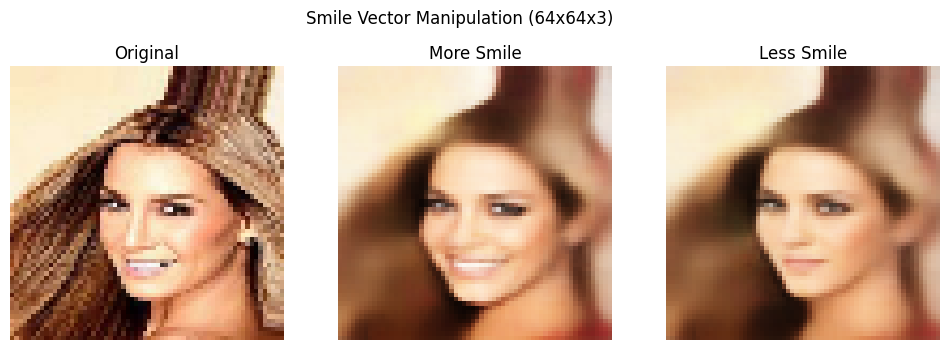

In [24]:
plt.figure(figsize=(12,4))
titles = ["Original", "More Smile", "Less Smile"]
images = [img_original, img_more_smile, img_less_smile]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.suptitle('Smile Vector Manipulation (64x64x3)')
plt.show()
